## Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, 
                      # giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)
import csv
from sklearn.linear_model import LinearRegression

## Thu thập dữ liệu

In [2]:
# Đọc dữ liệu từ "data.csv"
df = pd.read_csv('data_better_distribute.csv')
df

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29
1,2200.0,Single Family Residential,4,2.0,4234.0,3,260000,Forced Air (Natural Gas),Central A/C,NaN,Bungalow,1915.0,NaN,Chicago,1119 North Lockwood Avenue,2938.45
2,750.0,Condo/Coop,2,NaN,NaN,1,275000,Forced Air (Natural Gas),Central A/C,NaN,Other,1926.0,NaN,Chicago,1100 North Paulina Street #1M,4722.00
3,1248.0,Single Family Residential,3,2.0,5279.0,2,309900,NaN,Central A/C,NaN,Ranch,1962.0,NaN,Chicago,4909 North Normandy Avenue,560.03
4,1337.0,Single Family Residential,3,2.0,NaN,2,324900,Forced Air (Natural Gas),Central A/C,NaN,Georgian,1949.0,NaN,Chicago,10034 South Artesian Avenue,77.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,1939.0,Condo/Coop,2,1.0,NaN,3,525000,Forced Air (Natural Gas),Central A/C,NaN,Other,2001.0,NaN,Chicago,309 North Union Avenue #C,9314.65
1622,1400.0,Condo/Coop,2,1.0,NaN,2,425000,Forced Air (Natural Gas),Central A/C,NaN,Other,1998.0,NaN,Chicago,2251 West Saint Paul Avenue #2F,6445.46
1623,NaN,Condo/Coop,3,1.0,NaN,2,525000,Forced Air (Natural Gas),Central A/C,NaN,Other,NaN,NaN,Chicago,1423 West FLETCHER Street #CH,11275.42
1624,NaN,Condo/Coop,2,1.0,16207.0,2,499000,Forced Air (Natural Gas),Central A/C,NaN,Other,2000.0,True,Chicago,400 North CLINTON Street #404,9629.73


---

## Khám phá dữ liệu (để làm rõ câu hỏi)

### Số dòng và cột

In [3]:
df.shape

(1626, 16)

### Ý nghĩa của từng dòng. Có dòng nào không phù hợp không?

Mỗi dòng thể hiện 17 thông tin khác nhau của một căn nhà được giao bán. Do dữ liệu được lấy trong trang mô tả chi tiết của từng căn nhà nên sẽ không có dòng nào đặc biệt.

Tuy nhiên người đăng có thể giao bán 1 căn nhà nhiều lần, các dòng có thể bị lặp lại.

### Kiểm tra số dòng bị lặp lại

In [4]:
df.duplicated().sum()

48

$\to$ Sẽ được đưa vào Pipeline tiền xử lí chung trong tệp huấn luyện

### Ý nghĩa của mỗi cột

In [5]:
df.head(1)

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29


**Ý nghĩa của từng cột** 
- `beds` : Số phòng ngủ
- `baths` : Số phòng vệ sinh
- `house_type` : Loại hình nhà ở
- `sqlt` : Diện tích căn nhà
- `parkingSpots`: chỗ đỗ xe
- `address` : Địa chỉ của căn nhà
- `listPrice `: Giá tiền hiện giao bán
- `lotSize`: diện tích sử dụng
- `heating system`: hệ thống giữ nhiệt
- `cooling system`: hệ thống làm lạnh
- `view_type`: view của căn nhà
- `architecture_style`: phong cách thiết kế
- `yearBuilt`: năm xây dựng
- `has_pool`: số lượng hồ bơi
- `city`: thành phố
- `tax`: tiền thuế

### Làm rõ câu hỏi

**Câu hỏi đưa ra:** Với một căn nhà mơ ước, người khách hàng cần bao nhiêu tiền để có thể mua được ở bang Chicago của Mỹ ? 

Tạm thời các cột Input sẽ là thông tin liên quan tới căn nhà được giao bán, tổng cộng có 16 cột. Cột Output sẽ là giá bán của ngôi nhà. Nhóm sẽ sử dụng mô hình hồi quy để dự đoán giá nhà (cột Output) dựa trên thông tin của căn nhà (cột Input).

Các cột Input có thể thay đổi ở các bước tiền xử lý sau.

**Lợi ích khi trả lời**: 

Có thể đưa ra một mức giá sấp xỉ để những người trẻ có thể dựa vào đó để nổ lực phấn đấu mua được căn nhà mình muốn.

## Khám phá dữ liệu (để tách các tập)


Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít:
- Cột này hiện có kiểu dữ liệu là gì? Trong bài toán hồi qui thì cột output bắt buộc phải có dạng số; nếu hiện chưa có dạng số (ví dụ, số nhưng được lưu dưới dạng chuỗi) thì ta cần chuyển sang dạng số rồi mới tách các tập.
- Cột này có giá trị thiếu không? Nếu có giá trị thiếu thì ta sẽ bỏ các dòng mà output có giá trị thiếu rồi mới tách các tập 
- Cột numerical output xử lí như nào?

In [6]:
# Kiểu dữ liệu cột output
df['listPrice'].dtype

dtype('int64')

In [7]:
# Có giá trị nào thiếu không?
df['listPrice'].isna().sum()

0

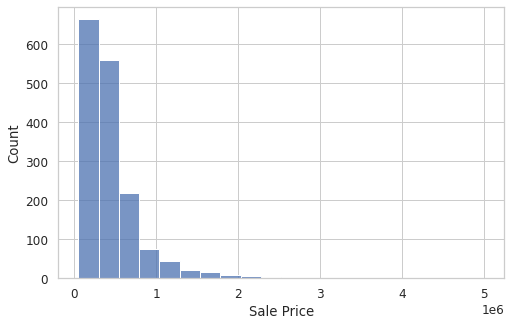

In [8]:
# Biểu đồ histogram của cột output
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.histplot(data =  df['listPrice'], bins=20).set(xlabel='Sale Price', ylabel='Count');

---

### Tiền xử lý tách tập dữ liệu

In [9]:
# Tách X và y
y = df["listPrice"] 
X = df.drop("listPrice", axis=1)

In [10]:
# Tách tập huấn luyện và tập validation và tập test theo tỉ lệ 60:20:20
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                               test_size=0.2,
                                               )

In [11]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                               test_size=0.2,
                                                )

In [12]:
print("train_X.shape: ", train_X.shape)
print("train_y.shape: ", train_y.shape)

print("val_X.shape: ", val_X.shape)
print("val_y.shape: ", val_y.shape)

print("test_X.shape: ", test_X.shape)
print("test_y.shape: ", test_y.shape)

train_X.shape:  (1040, 15)
train_y.shape:  (1040,)
val_X.shape:  (260, 15)
val_y.shape:  (260,)
test_X.shape:  (326, 15)
test_y.shape:  (326,)


---

## Khám phá dữ liệu (trên tập train)

### Kiểu dữ liệu từng cột. Có cột nào chưa phù hợp?

In [13]:
train_X.dtypes

sqft                  float64
homeType               object
beds                    int64
parkingSpots          float64
lotSize               float64
baths                   int64
heating_system         object
cooling_system         object
view_type             float64
architecture_style     object
yearBuilt             float64
has_pool               object
city                   object
address                object
tax                   float64
dtype: object

### Các cột dạng numerical phân bố như thế nào?

In [14]:
train_X.dtypes[train_X.dtypes != object]

sqft            float64
beds              int64
parkingSpots    float64
lotSize         float64
baths             int64
view_type       float64
yearBuilt       float64
tax             float64
dtype: object

In [15]:
num_cols = ['sqft',"beds","parkingSpots","lotSize","baths","view_type","yearBuilt","tax"]
num_df = train_X[num_cols]
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
num_df.agg([missing_percentage, 'min', median, 'max'])

,sqft,beds,parkingSpots,lotSize,baths,view_type,yearBuilt,tax
missing_percentage,22.5,0.0,15.2,52.1,0.0,100.0,10.9,4.6
min,600.0,0.0,0.0,0.0,1.0,NaN,1868.0,77.4
median,1455.0,3.0,2.0,3781.0,2.0,NaN,1958.0,4391.4
max,6315.0,4.0,100.0,5225894.0,5.0,NaN,2022.0,730774.0


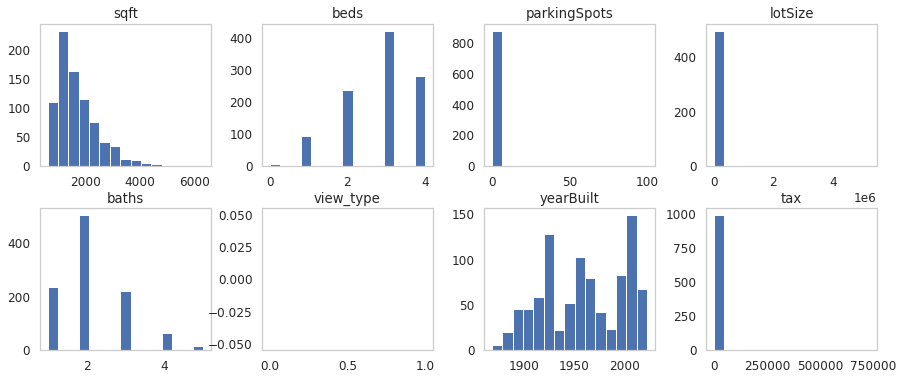

In [16]:
num_df[num_cols].hist(bins=15, figsize=(15, 6), layout=(2, 4),grid=False);

### Các cột dạng categorical phân bố như thế nào?

In [17]:
train_X.dtypes[train_X.dtypes == object]

homeType              object
heating_system        object
cooling_system        object
architecture_style    object
has_pool              object
city                  object
address               object
dtype: object

In [18]:
cate_cols = list(set(train_X.columns) - set(num_cols))
cate_df = train_X[cate_cols]
pd.set_option('display.max_colwidth', 200)
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
cate_df.agg([missing_percentage, num_values, value_percentages])

,address,heating_system,city,cooling_system,architecture_style,homeType,has_pool
missing_percentage,0.0,27.1,0.0,1.1,0.0,0.0,98.0
num_values,1016,23,1,5,16,4,1
value_percentages,"{'1341 West Ancona Street': 0.2, '1025 West Buena Avenue #4W': 0.2, '2437 North Albany Avenue #2': 0.2, '10826 South Longwood Drive': 0.2, '3817 West 55th Place': 0.2, '5625 North Kenmore Avenue #...","{'Forced Air (Natural Gas)': 61.2, 'Fireplace (Natural Gas)': 11.3, 'Forced Air': 7.3, 'Hot Water': 3.2, 'Radiator': 3.0, 'Hot Water (Natural Gas)': 2.0, 'Baseboard': 2.0, 'Forced Air (Electric)':...",{'Chicago': 100.0},"{'Central A/C': 80.4, 'Window Unit(s) A/C': 9.7, 'None': 9.3, 'Zoned A/C': 0.5, 'Partial': 0.1}","{'Other': 66.4, 'High Rise': 8.6, 'Bungalow': 6.4, 'Ranch': 6.1, 'Loft': 2.9, 'Cape Cod': 2.3, 'Georgian': 1.7, 'Split Level': 1.4, 'Contemporary': 1.2, 'New Traditional': 0.7, 'Tudor': 0.5, 'Colo...","{'Single Family Residential': 50.0, 'Condo/Coop': 49.2, 'Townhouse': 0.4, 'Other': 0.4}",{True: 100.0}


## Tiền xử lý tập train

### Cột dạng numerical

- Điền các giá trị thiếu là median 
- Các cột có missing_percentage lớn hơn 40% sẽ được loại bỏ: lotSize, view_type \
$\to$ Các cột numerical còn lại: `sqft`,`beds`,`parkingSpots`,`baths`,`yearBuilt`,`tax`

In [19]:
class NumeDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        # bỏ cột      
        self.newX_df=self.newX_df.drop(columns=["lotSize","view_type","yearBuilt"])
        return self.newX_df

- Loại bỏ outliers cột numerical

In [20]:
outliers_index = set()
num_cols = ['sqft',"beds","parkingSpots","baths","tax"]

def outliers_removed(col):
    if col.name in num_cols:
        data_std = col.std()    
        data_mean = col.mean()
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        outliers_removed = (col < lower) | (col > upper)
        outliers_index.update(set(col[outliers_removed].index.values))
    return col

train_X.apply(outliers_removed)
train_X = train_X.drop(list(outliers_index))
train_y = train_y.drop(list(outliers_index))

### Cột dạng categorical

- Các cột có missing_percentage lớn hơn 40% sẽ được loại bỏ: has_pool
- Điền các giá trị thiếu bằng most-frequent
- Address tách tên đường 
- Các cột chỉ có 1 giá trị sẽ được loại bỏ: city
- heating_system, home_type, architecture_type, cooling_system, address sau khi tách sẽ được chuyển thành dạng one-hot

**Tách tên đường**

In [21]:
street_col = train_X["address"].str.extract('(?P<number>\d+)(?P<Street>.*)')
street_col = street_col.Street.str.split("#").str[0]
street_col = street_col.str.strip()
street_col.agg([num_values, value_percentages]).to_frame()

,Street
num_values,602
value_percentages,"{'North Lake Shore Drive': 2.1, 'South State Street': 0.9, 'North Paulina Street': 0.9, 'North Sheridan Road': 0.7, 'South Michigan Avenue': 0.7, 'North Wolcott Avenue': 0.7, 'West Diversey Parkwa..."


Có nhiều giá trị rời rạc trong cột "street_col", và phần trăm đóng góp từng giá trị quá nhỏ \
$\to$ Bỏ cột "address"

In [22]:
def fit_col(X, num_top_titles):
    self = X.value_counts()
    index = list(self.index)
    self = index[:max(1, min(num_top_titles, len(index)))]
    return self

def transform_col(self, X):
    return np.where(X.isin(self),X,"Others")

In [23]:
class CateDropper(BaseEstimator, TransformerMixin):
    def __init__(self, n=1):
        self.n = n
        self.top_cols = ["heating_system", "homeType", "architecture_style", "cooling_system"]
    def fit(self, X, y=None):
        self.heat_counts = fit_col(X.heating_system, self.n )
        self.homeType = fit_col(X.homeType,self.n)
        self.architecture_style = fit_col(X.architecture_style,self.n)
        self.cooling_system = fit_col(X.cooling_system,self.n)
        
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        
        self.newX_df["heating_system"] = transform_col(self.heat_counts, self.newX_df["heating_system"])
        self.newX_df["homeType"] = transform_col(self.homeType, self.newX_df["homeType"])
        self.newX_df["architecture_style"] = transform_col(self.architecture_style, self.newX_df["architecture_style"])
        self.newX_df["cooling_system"] = transform_col(self.cooling_system, self.newX_df["cooling_system"])

        # bỏ cột       
        self.newX_df=self.newX_df.drop(columns=["has_pool","city","address"])
        return self.newX_df

### Toàn bộ quá trình xử lý sẽ được thực hiện như sau:
- Xử lý các cột dạng số: bỏ đi lotSize và view_type, điền các giá trị thiếu bằng median
- Xử lý các cột dạng categorical: bỏ đi has_pool, address, city. Điền các giá trị thiếu bằng most-frequent, lấy top N giá trị xuất hiện nhiều nhất của các cột còn lại, chuyển thành Onehot

In [24]:
num_cols = ["sqft", "beds" , "baths","parkingSpots","tax"]
cate_cols = ["homeType", "heating_system", "cooling_system","architecture_style" ]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))])


categotical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('nume', numeric_transformer, num_cols),
        ('cate',categotical_transformer , cate_cols)])


preprocess_pipeline = Pipeline(steps=[('numdropper',NumeDropper()),
                                      ('catedropper', CateDropper(n=3)),
                                      ('preprocessor', preprocessor),
                                      ('minmax', MinMaxScaler())])

preprocess_pipeline

Pipeline(steps=[('numdropper', NumeDropper()),
                ('catedropper', CateDropper(n=3)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('nume',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['sqft', 'beds', 'baths',
                                                   'parkingSpots', 'tax']),
                                                 ('cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['homeType', 'heating_system',
                                                   'cooling_system',
                                                   'architecture_style'])])),
                ('minmax', MinMaxScaler())])

## Mối quan hệ với cột Output

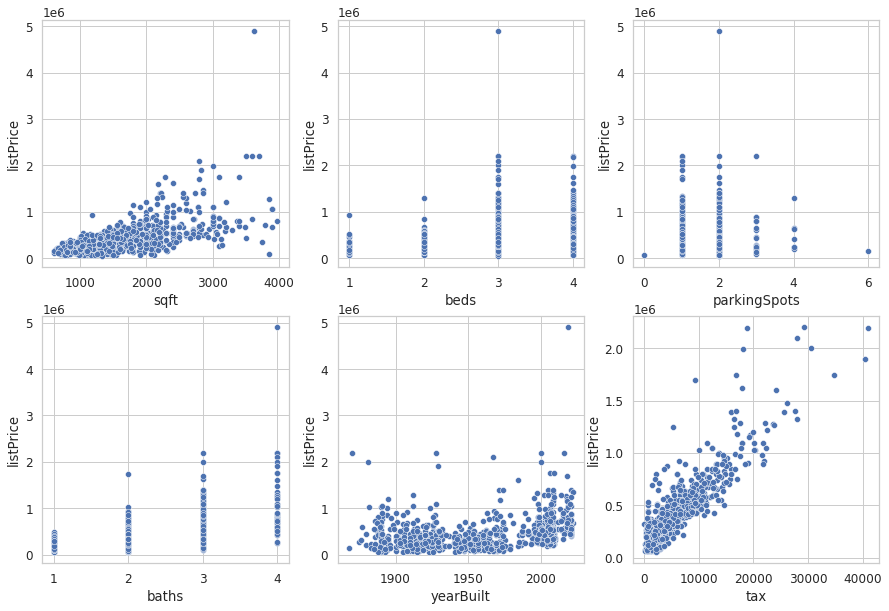

In [25]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))
num_df = num_df.drop(columns=["lotSize","view_type"])
for var, subplot in zip(num_df, ax.flatten()):
    sns.scatterplot(x=train_X[var],y=train_y, ax=subplot);

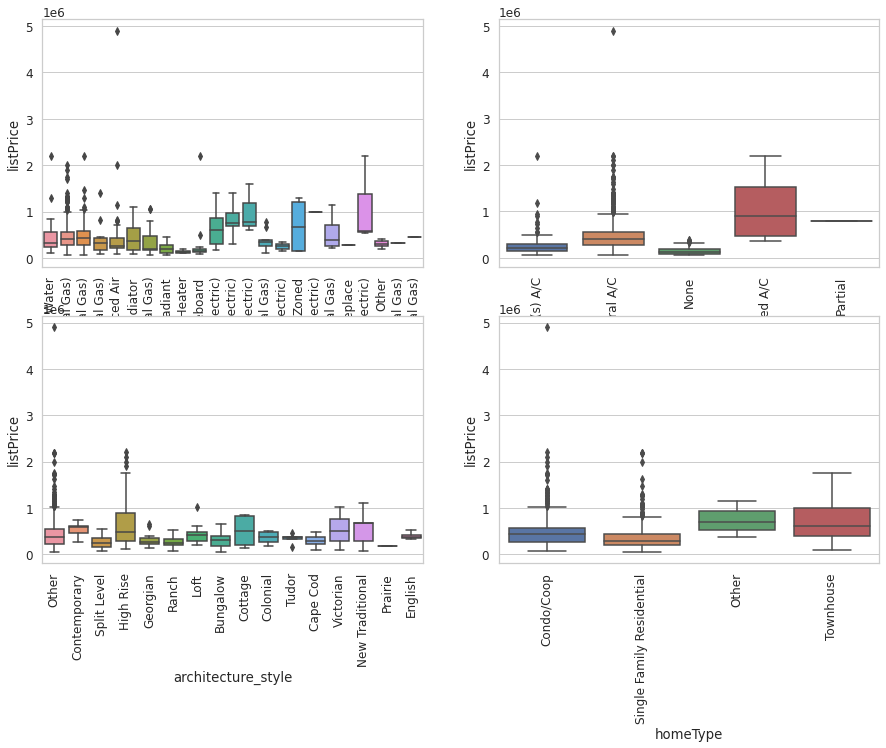

In [26]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))
cate_df = cate_df.drop(columns=["city","address","has_pool"])
for var, subplot in zip(cate_df, ax.flatten()):
    g=sns.boxplot(x=train_X[var],y=train_y, ax=subplot)
    g.tick_params(axis='x', rotation=90)

In [27]:

# Correlation Matrix Heatmap
# f, ax = plt.subplots(figsize=(10, 6))
# corr = train_pd.corr()
# hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
#                  linewidths=.05)
# f.subplots_adjust(top=0.93)
# t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

## Mô hình hóa

#### Hàm tính RR

In [28]:
def compute_mse(y, preds):
    return ((y - preds)**2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)
baseline_preds = test_y.mean()

#### Bỏ outliers cho output

In [29]:
cut_off = train_y.std() * 3
lower, upper = train_y.mean() - cut_off, train_y.mean() + cut_off
outliers_removed = (train_y < lower) | (train_y > upper)
outliers_index = set(train_y[outliers_removed].index.values)

train_X = train_X.drop(list(outliers_index))
train_y = train_y.drop(list(outliers_index))

### MLPRegressor

In [30]:
model = MLPRegressor(solver='sgd', 
                    activation = 'relu',
                    hidden_layer_sizes=(30,10), 
                    random_state=None,
                    max_iter = 3000,
                    alpha=1e-5)
full_pipeline = Pipeline(steps=[('preprocess_pipeline', preprocess_pipeline),
                                 ('neural_network',model)])
full_pipeline

Pipeline(steps=[('preprocess_pipeline',
                 Pipeline(steps=[('numdropper', NumeDropper()),
                                 ('catedropper', CateDropper(n=3)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('nume',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['sqft',
                                                                    'beds',
                                                                    'baths',
                                                                    'parkingSpots',
                                                                    'tax']),
                                                                  ('cate',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['homeType',
                                                                    'heating_system',
                                                                    'cooling_system',
                                                                    'architecture_style'])])),
                                 ('minmax', MinMaxScaler())])),
                ('neural_network',
                 MLPRegressor(alpha=1e-05, hidden_layer_sizes=(30, 10),
                              max_iter=3000, solver='sgd'))])

In [31]:
max_ = train_y.mean()
min_ = train_y.min()
scaleTrain_y=(train_y /min_)

In [32]:
train_errs = []
val_errs = []
alphas = [ 0.01 ,0.1, 1, 10]
N = [2,3,4,5]

best_val_err = float('inf')
best_N = None
best_alpha = None

for alpha in alphas:
    for n_ in N:
        model = full_pipeline.set_params(preprocess_pipeline__catedropper__n = n_, neural_network__alpha=alpha).fit(train_X, scaleTrain_y)
        train_error = compute_mse(train_y, model.predict(train_X)*min_)
        val_error = compute_mse(val_y, model.predict(val_X)*min_)
        
        train_errs.append(train_error)
        val_errs.append(val_error)
        
        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_N = n_

In [33]:
model = full_pipeline.set_params(preprocess_pipeline__catedropper__n = best_N, neural_network__alpha=best_alpha)
model = full_pipeline.fit(train_X, scaleTrain_y)

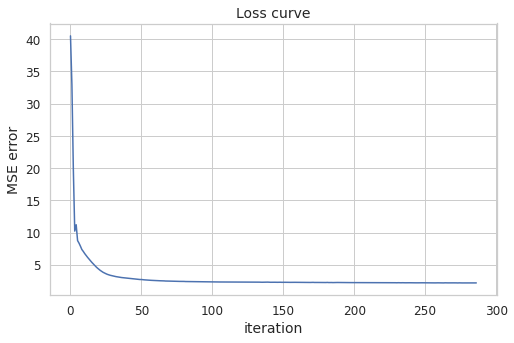

In [34]:
loss_values=model["neural_network"].loss_curve_
plt.plot(loss_values)
plt.title('Loss curve', fontsize=14)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('MSE error', fontsize=14)
plt.show()

In [35]:
#tính độ lỗi trên tập test
test_preds = model.predict(test_X)*min_

# test_preds= np.round(test_preds,3)
compute_rr(test_y, test_preds, baseline_preds)

0.6535125512043465

In [36]:
df = pd.DataFrame({'Actual': test_y, 'Predicted': test_preds})
df.head(10)

,Actual,Predicted
1303,419000,5.344653e+05
891,3499888,1.097766e+06
1116,215000,2.456133e+05
128,869900,8.788743e+05
927,145000,1.690787e+05
61,230000,2.255050e+05
1320,625000,6.301454e+05
1389,1085000,8.688892e+05
473,639900,5.933849e+05
1589,899000,9.686646e+05


### Linear Regression

#### Full pipeline

In [37]:
model = LinearRegression()
full_pipeline = Pipeline(steps=[('preprocess_pipeline', preprocess_pipeline),
                                 ('neural_network',model)])
full_pipeline

Pipeline(steps=[('preprocess_pipeline',
                 Pipeline(steps=[('numdropper', NumeDropper()),
                                 ('catedropper', CateDropper(n=4)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('nume',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['sqft',
                                                                    'beds',
                                                                    'baths',
                                                                    'parkingSpots',
                                                                    'tax']),
                                                                  ('cate',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['homeType',
                                                                    'heating_system',
                                                                    'cooling_system',
                                                                    'architecture_style'])])),
                                 ('minmax', MinMaxScaler())])),
                ('neural_network', LinearRegression())])

#### Tìm N
Vói N là sô lượng các giá trị xuất hiện nhiều nhất sao cho độ lỗi trên tập validation là nhỏ nhất

In [38]:
train_errs = []
best_val_err = float('inf')
val_errs = []

best_N = None
N = [1,2,3,4,5,6]
for i in N:
    model = full_pipeline.set_params(preprocess_pipeline__catedropper__n=i).fit(train_X, train_y)
    train_error = compute_mse(train_y, model.predict(train_X))
    val_error = compute_mse(val_y, model.predict(val_X))
    
    train_errs.append(train_error)
    val_errs.append(val_error)
    
    if val_errs[-1] < best_val_err:
        best_val_err = val_errs[-1]
        best_N = i

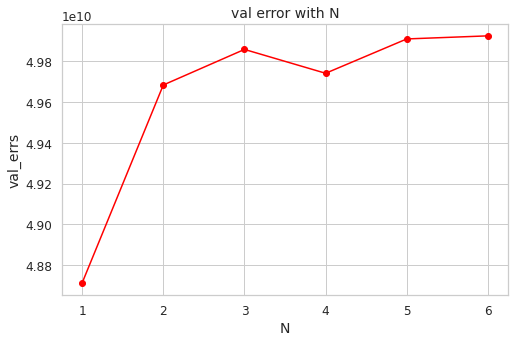

In [39]:
plt.plot(N, val_errs, color='red', marker='o')
plt.title('val error with N', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('val_errs', fontsize=14)
plt.show()

#### Train model 

In [40]:
model = full_pipeline.set_params(preprocess_pipeline__catedropper__n=best_N).fit(train_X, train_y)

#### Predict trên tập test

In [41]:
test_preds = model.predict(test_X)

In [42]:
df = pd.DataFrame({'Actual': test_y, 'Predicted': test_preds})
df

,Actual,Predicted
1303,419000,527360.0
891,3499888,1114112.0
1116,215000,242688.0
128,869900,882688.0
927,145000,177152.0
...,...,...
462,50900,111616.0
68,320000,305152.0
601,680000,805888.0
1187,1099000,1316864.0


#### Độ chính xác trên tập test

In [43]:
compute_rr(test_y, test_preds, baseline_preds)

0.7001855663582763